In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### data set reading

In [2]:
#read the stock price data from a CSV file
# df = pd.read_csv('RELIANCE.csv') ##Source File to be changed here
# df
# File paths
dataset_path = "/kaggle/input/reliance/RELIANCE.csv"

# Load CSV dataset into Pandas DataFrame
df = pd.read_csv(dataset_path)
df

,Date,Close/Last,Volume,Open,High,Low
0,03/1/2000,233.05,4456424,237.50,251.70,237.50
1,04/1/2000,251.70,9487878,258.40,271.85,251.30
2,05/1/2000,271.85,26833684,256.65,287.90,256.65
3,06/1/2000,282.50,15682286,289.00,300.70,289.00
4,07/1/2000,294.35,19870977,295.00,317.90,293.00
...,...,...,...,...,...,...
5070,22/5/2020,1441.25,17458503,1451.80,1458.00,1426.50
5071,26/5/2020,1431.55,15330793,1448.15,1449.70,1416.30
5072,27/5/2020,1424.05,16460764,1431.00,1454.00,1412.00
5073,28/5/2020,1445.55,18519252,1455.00,1479.75,1449.00


### preprocessing data set to perform analysis

In [3]:
df.shape

(5075, 6)

In [4]:
df.tail(10)

,Date,Close/Last,Volume,Open,High,Low
5065,15/5/2020,1435.95,28683432,1444.00,1466.70,1415.10
5066,18/5/2020,1459.40,28981620,1470.00,1482.00,1428.00
5067,19/5/2020,1440.75,19529216,1457.00,1461.70,1403.25
5068,20/5/2020,1408.90,25530692,1410.00,1446.85,1393.00
5069,21/5/2020,1433.70,18077196,1435.00,1461.45,1425.00
5070,22/5/2020,1441.25,17458503,1451.80,1458.00,1426.50
5071,26/5/2020,1431.55,15330793,1448.15,1449.70,1416.30
5072,27/5/2020,1424.05,16460764,1431.00,1454.00,1412.00
5073,28/5/2020,1445.55,18519252,1455.00,1479.75,1449.00
5074,29/5/2020,1472.25,18471770,1468.00,1472.00,1452.65


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5075 entries, 0 to 5074
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        5075 non-null   object 
 1   Close/Last  5075 non-null   float64
 2   Volume      5075 non-null   int64  
 3   Open        5075 non-null   float64
 4   High        5075 non-null   float64
 5   Low         5075 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 238.0+ KB


In [6]:
df1 = df.iloc[:,1] # select the second column (assumed to be stock prices)
df1.head()

0    233.05
1    251.70
2    271.85
3    282.50
4    294.35
Name: Close/Last, dtype: float64

 **Data Selection and Cleaning**

In [7]:
#Selects the stock price column
df1 = df1.replace('[\$,]', '', regex=True).astype(float)

#removes unwanted symbols(e.g, $) using regex and convert it to a numeric format
df1.head()

0    233.05
1    251.70
2    271.85
3    282.50
4    294.35
Name: Close/Last, dtype: float64

**Visualizing the Data**

Text(0, 0.5, 'stock price')

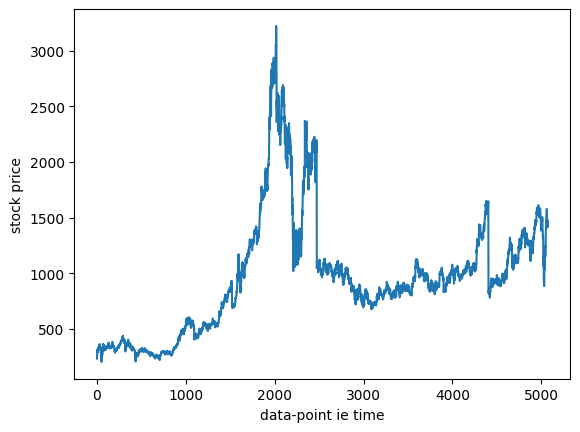

In [8]:
#Plots the stock price data over time.
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

**Normalizing the Data**

In [9]:
#Scales stock prices into the range[0,1] for compatibility with LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [10]:
df1.shape

(5075,)

In [11]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))  #scale data between 0 and 1

In [12]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[0.0098918 ]
 [0.01607211]
 [0.02274949]
 ...
 [0.40456978]
 [0.41169453]
 [0.42054248]]

 df1 present shape :  (5075, 1)


### splitting data (70/30)

In [13]:
#Splits the data into trainning 70% and testing 30% subsets
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  3552
Test Size :  1523


In [14]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (3552, 1)
Test Data Shape:  (1523, 1)


### | windowing data set |

In [15]:
#sliding window: Creates sequences of window lenght for input(X) and the next value as output(y)

def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

**Reshaping Data for LSTM**

In [16]:
#Reshapes the data to 3D(samples,time_steps,features) required for LSTM

window = 100 #size of sliding window means create sequences of 100 timsteps for each input
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3451, 100) (3451,)
(1422, 100) (1422,)


In [18]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [19]:
#Building LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
#Construct a sequential model with:
# 3 LSTM layers(50 neurons each)
#A dense layer for prediction
#loss function: Mean Squared Error
#Optimizer:Adam

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1))) #First LSTM layer
model.add(LSTM(50, return_sequences = True)) # Second LSTM layer
model.add(LSTM(50)) # Third LSTM layer
model.add(Dense(1)) # Fully connected output layer

model.compile(loss='mean_squared_error', optimizer = 'adam') # Compile model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

### fitting data to model

In [22]:
#Training the model
#Trains the LSTM model on the training data for 25 epochs with a batch size of 30
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 25, batch_size=30,verbose=1)

Epoch 1/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - loss: 0.0129 - val_loss: 8.8910e-04
Epoch 2/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - loss: 9.5551e-04 - val_loss: 0.0011
Epoch 3/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - loss: 9.9424e-04 - val_loss: 6.6947e-04
Epoch 4/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 7.1287e-04 - val_loss: 4.9790e-04
Epoch 5/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 5.5478e-04 - val_loss: 0.0010
Epoch 6/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - loss: 9.9951e-04 - val_loss: 3.9953e-04
Epoch 7/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 5.6538e-04 - val_loss: 3.9358e-04
Epoch 8/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 4.6964e-04 - val_loss: 3.6660e-04
Epoch 9/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 6.1414e-04 - val_loss: 3.1979e-04
Epoch 10/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 3.3932e-04 - val_loss: 3.9942e-04
Epoch 11/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
y_pred = scaler.inverse_transform(model.predict(X_test)) #predict test data

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


In [24]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)) #Scale back test data

In [25]:
y_pred[:5]

array([[984.1788 ],
       [994.5159 ],
       [999.06024],
       [994.9946 ],
       [989.00885]], dtype=float32)

In [26]:
y_test[:5]

array([[1013.05],
       [1009.3 ],
       [ 998.35],
       [ 995.1 ],
       [ 998.3 ]])

### Model Evaluation

In [27]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred)) #Compute RMSE
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  34.446093888535195


In [28]:

from sklearn.metrics import r2_score


# Step 5: Calculate the R² score
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)



R² score: 0.9727159833173278


### visualization + plotting

108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


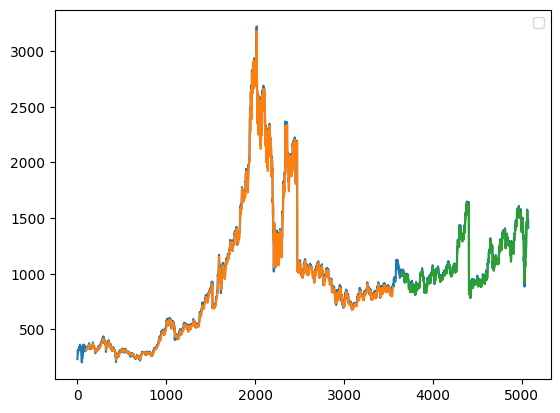

In [29]:
# shift train predictions for plotting

train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1) 
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1)) #Original data
plt.plot(trainPredictPlot) #Training predictions
plt.plot(testPredictPlot) #Testing predictions
plt.legend()
plt.show()

### predicting 30 Days future value

In [30]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [32]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):   #Predict 30 future data points
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [33]:
day_new=np.arange(1,101) #Last 100 days
day_pred=np.arange(101,131) #Next 30 days

In [34]:
print(scaler.inverse_transform(lst_output))

[[1450.75683805]
 [1446.50759476]
 [1437.0631032 ]
 [1426.89833841]
 [1416.72610918]
 [1406.87323196]
 [1397.46345453]
 [1388.47744128]
 [1379.82912637]
 [1371.41472714]
 [1363.14278174]
 [1354.94673977]
 [1346.78658107]
 [1338.64521835]
 [1330.52121271]
 [1322.42274802]
 [1314.36241492]
 [1306.35280402]
 [1298.40479721]
 [1290.52612873]
 [1282.72210462]
 [1274.99371414]
 [1267.34122709]
 [1259.76311462]
 [1252.25694854]
 [1244.81886171]
 [1237.44696556]
 [1230.13784263]
 [1222.88924459]
 [1215.69847345]]


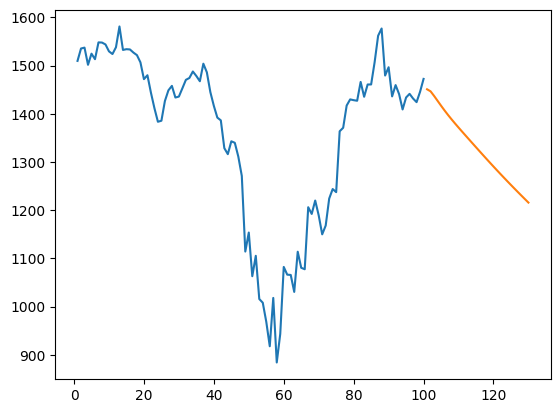

In [35]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))